# KLIFS pocket

In [1]:
import numpy as np
import pandas as pd
import copy
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from missense_kinase_toolkit.databases import klifs, colors, kinase_schema
from missense_kinase_toolkit.databases.klifs import KLIFSPocket

## Load data

In [2]:
# files generated in databases.ipynb must be in data directory
dict_kinase = kinase_schema.create_kinase_models_from_df()

dict_klifs = {i: j for i, j in dict_kinase.items() if \
              (j.KLIFS is not None and j.KLIFS.pocket_seq is not None)}

In [3]:
# check that all KLIFS2UniProt alignments working as expected - should be no output
for hgnc, pocket in dict_klifs.items():
    list_temp = [pocket.UniProt.canonical_seq[val-1] == pocket.KLIFS.pocket_seq[idx] \
                 for idx, (key, val) in enumerate(pocket.KLIFS2UniProt.items()) if val is not None]
    not any(list_temp)

## Assess AA conservation of KLIFS pocket

In [4]:
dict_pocket = {key : {idx + 1 : aa for idx, aa in enumerate(val.KLIFS.pocket_seq)}\
               for key, val in dict_klifs.items()}
df_pocket = pd.DataFrame(dict_pocket).T

In [5]:
df_pocket_melt = pd.melt(df_pocket.reset_index(), id_vars='index')
df_pocket_melt.columns = ["gene_name", "position", "amino_acid"]

In [6]:
df_pocket_pivot = df_pocket_melt.pivot_table(index="amino_acid", columns="position", values="amino_acid", aggfunc="count")
# otherwise numeric
# df_pocket_pivot.columns = [str(col) for col in df_pocket_pivot.columns]
# df_pocket_pivot.loc[df_pocket_pivot.index == "K", 17]

In [7]:
df_pocket_count = pd.DataFrame(df_pocket_melt[["position", "amino_acid"]].value_counts())
df_pocket_count = df_pocket_count.reset_index()

ALPHABET_PROJECT
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ASAP
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
RASMOL
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
SHAPELY
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
CLUSTALX
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ZAPPO
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.


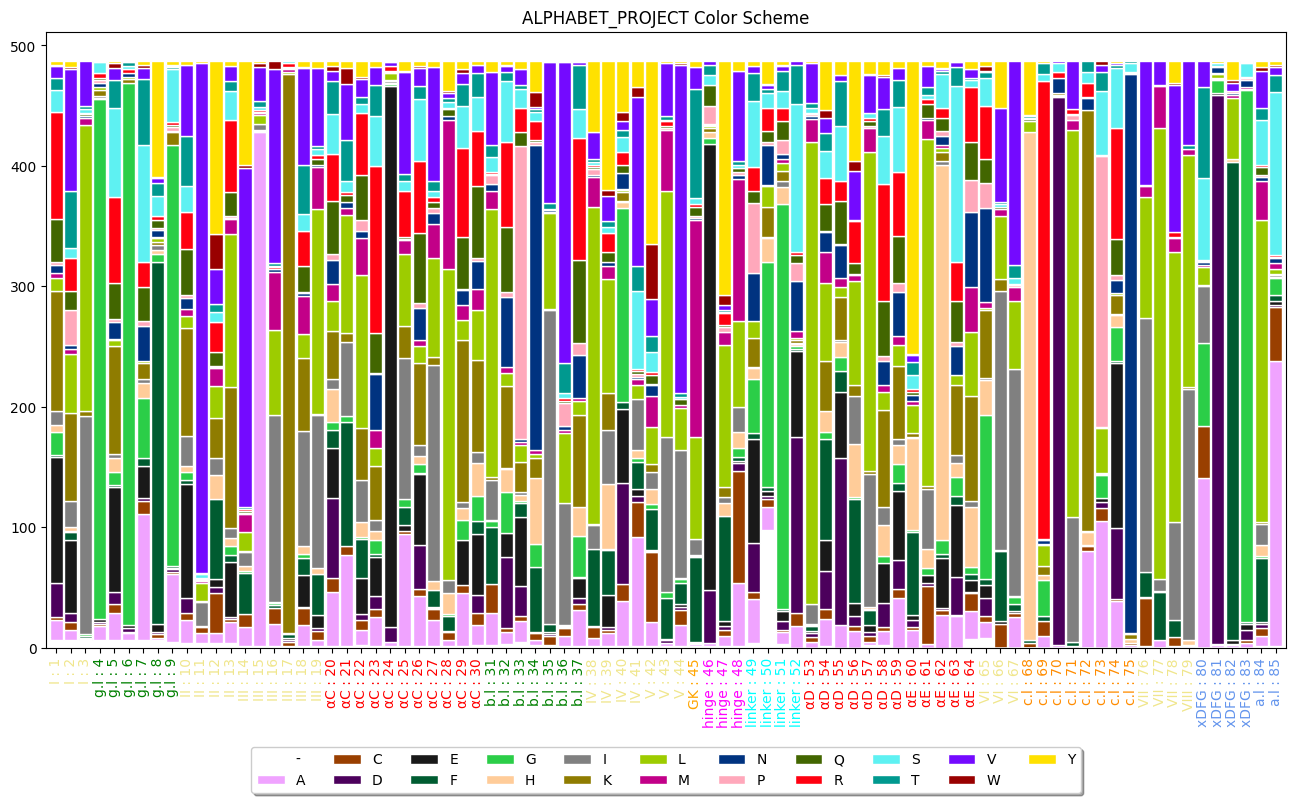

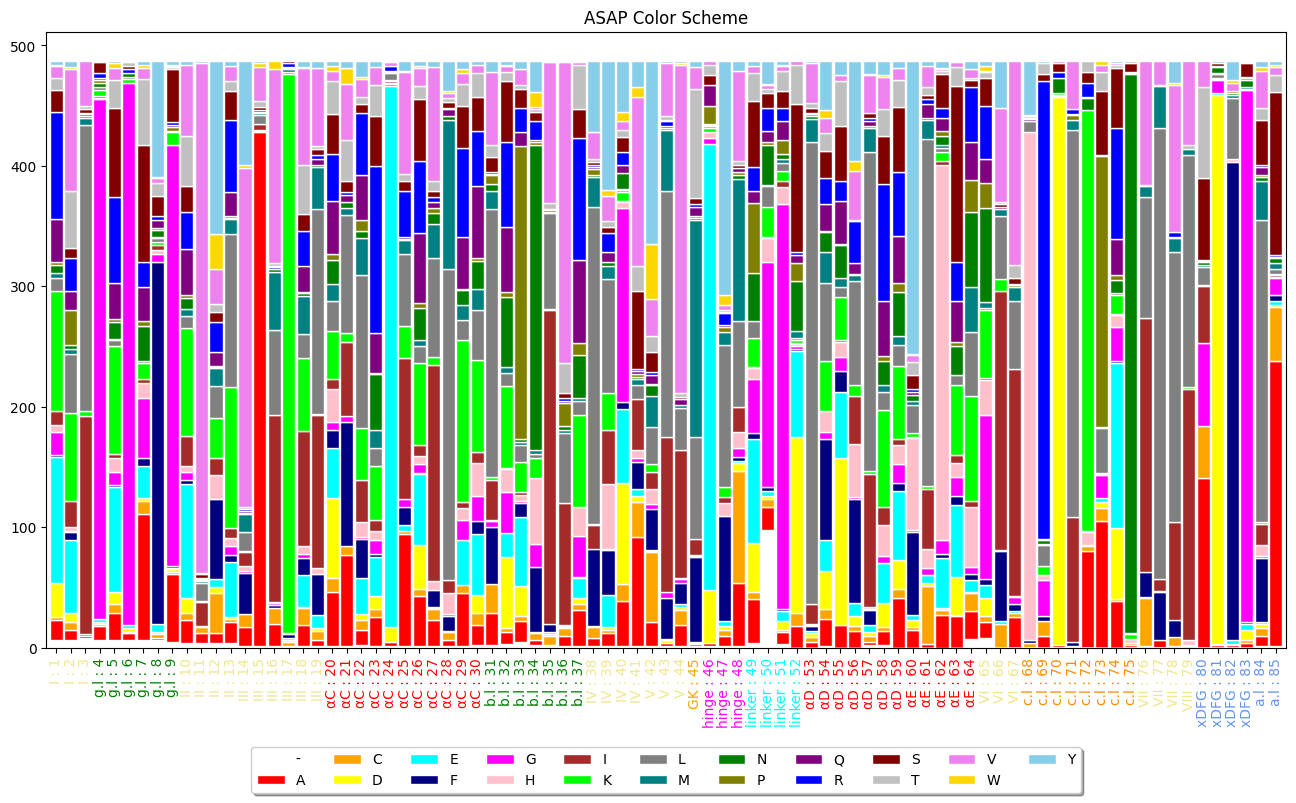

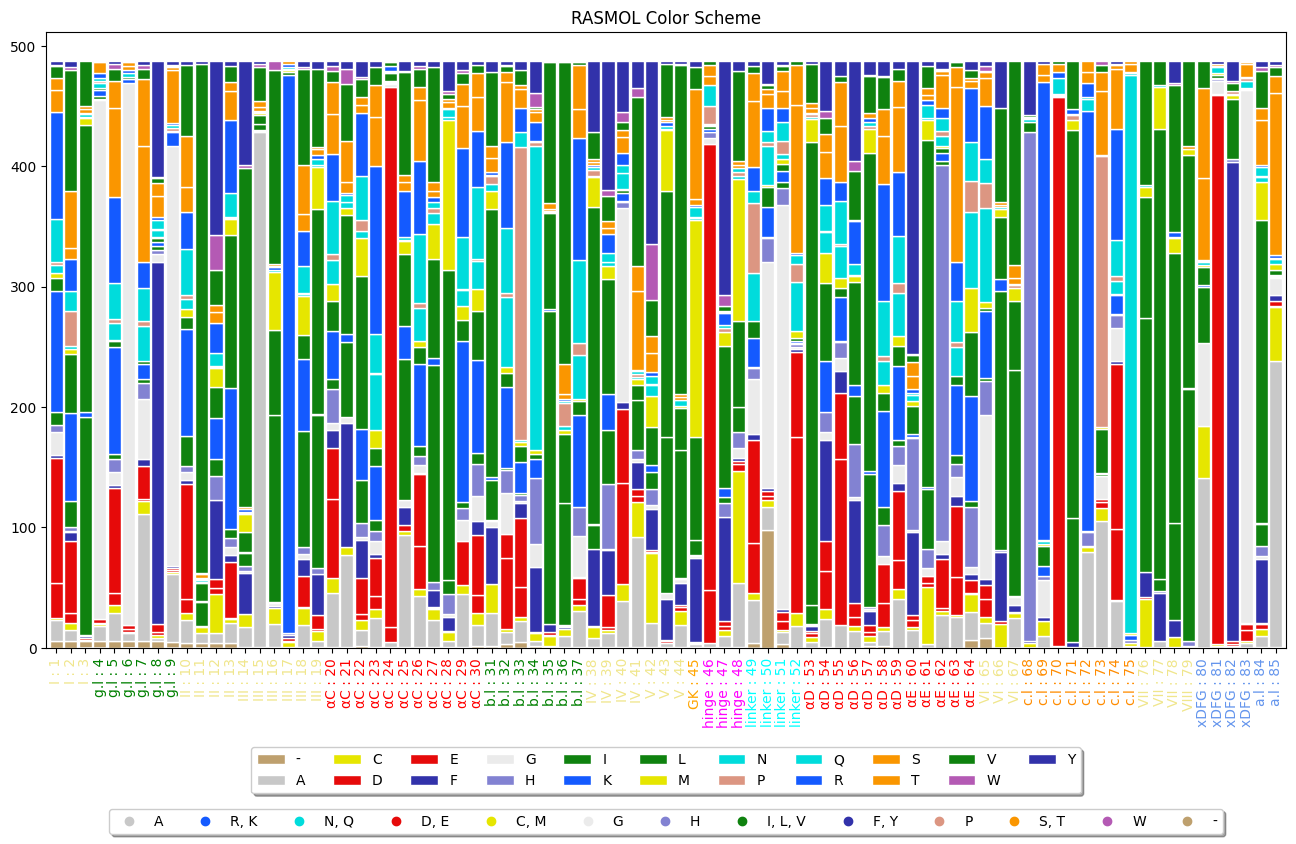

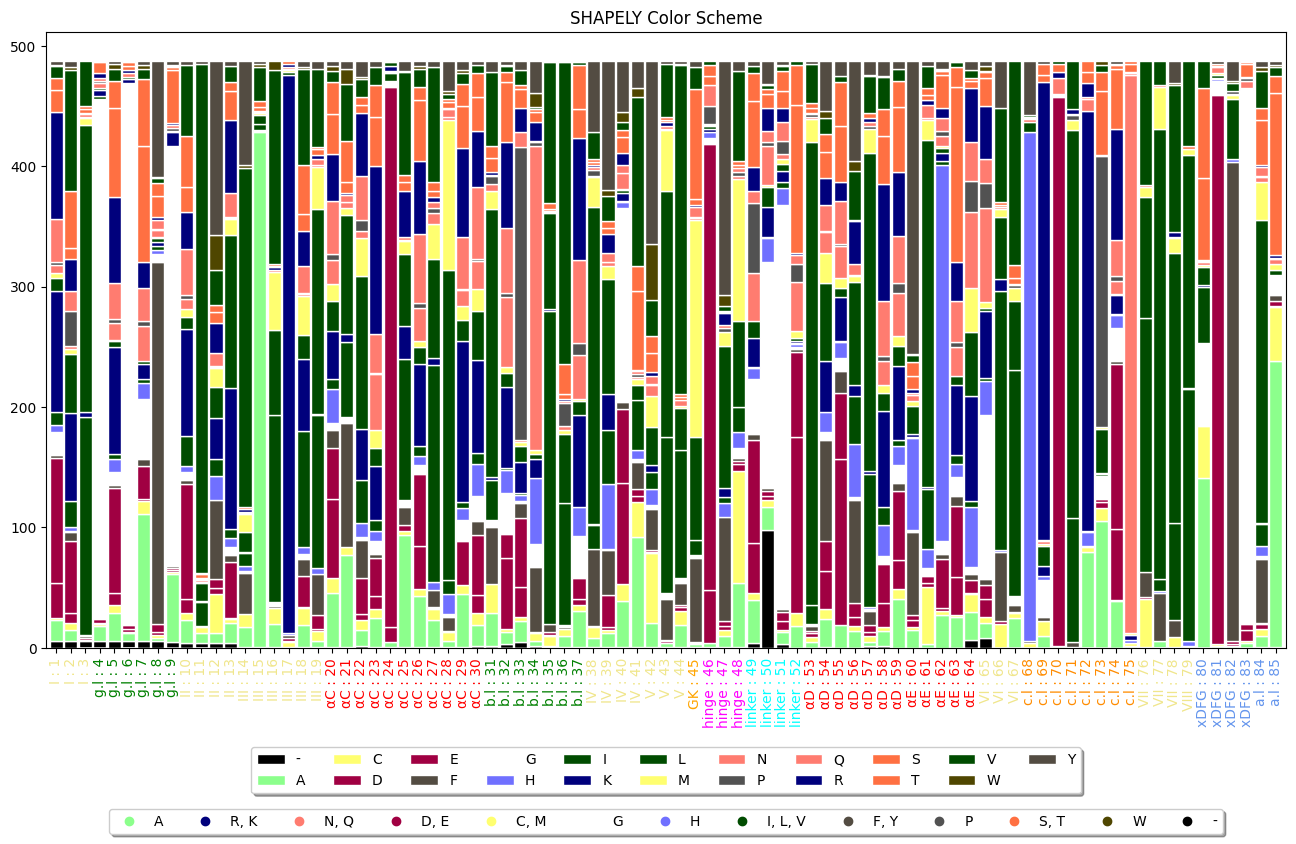

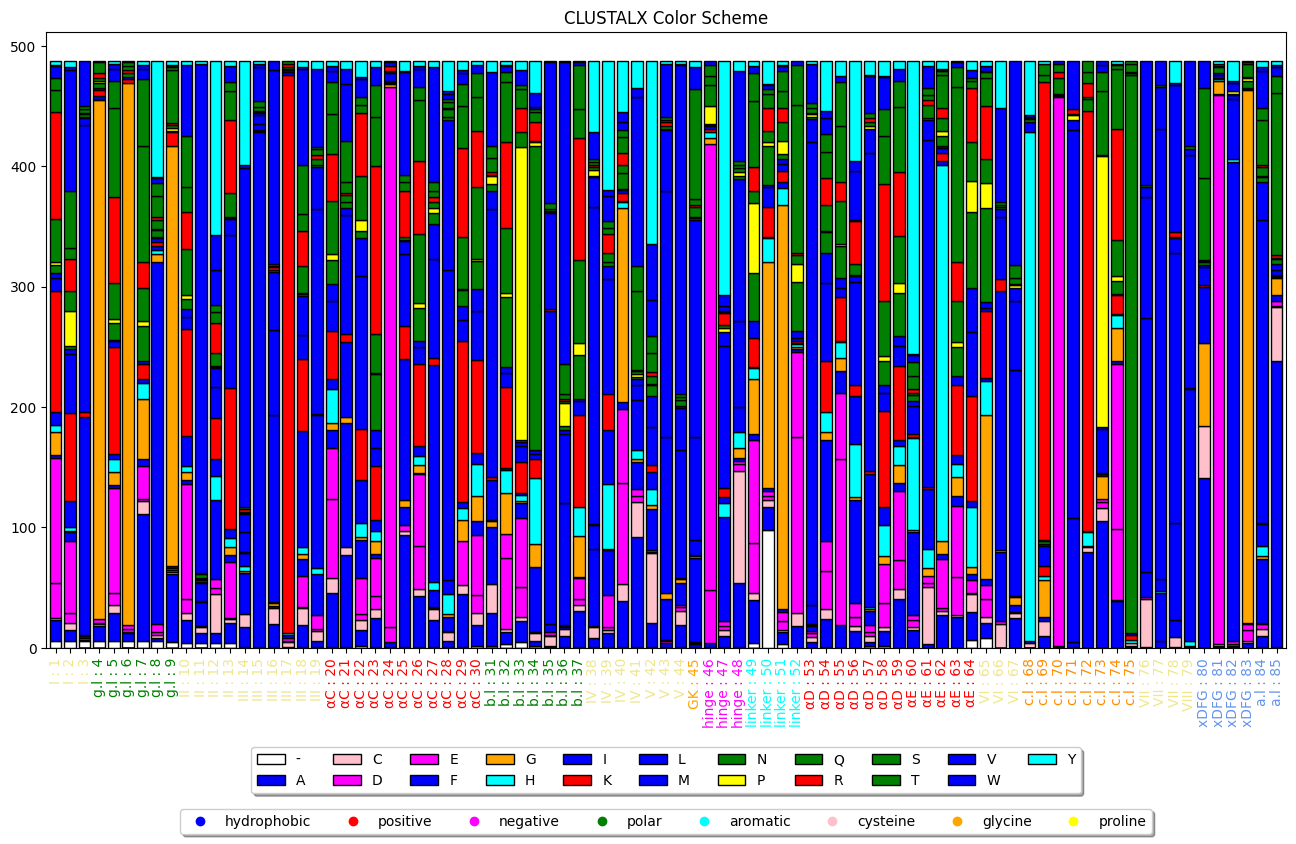

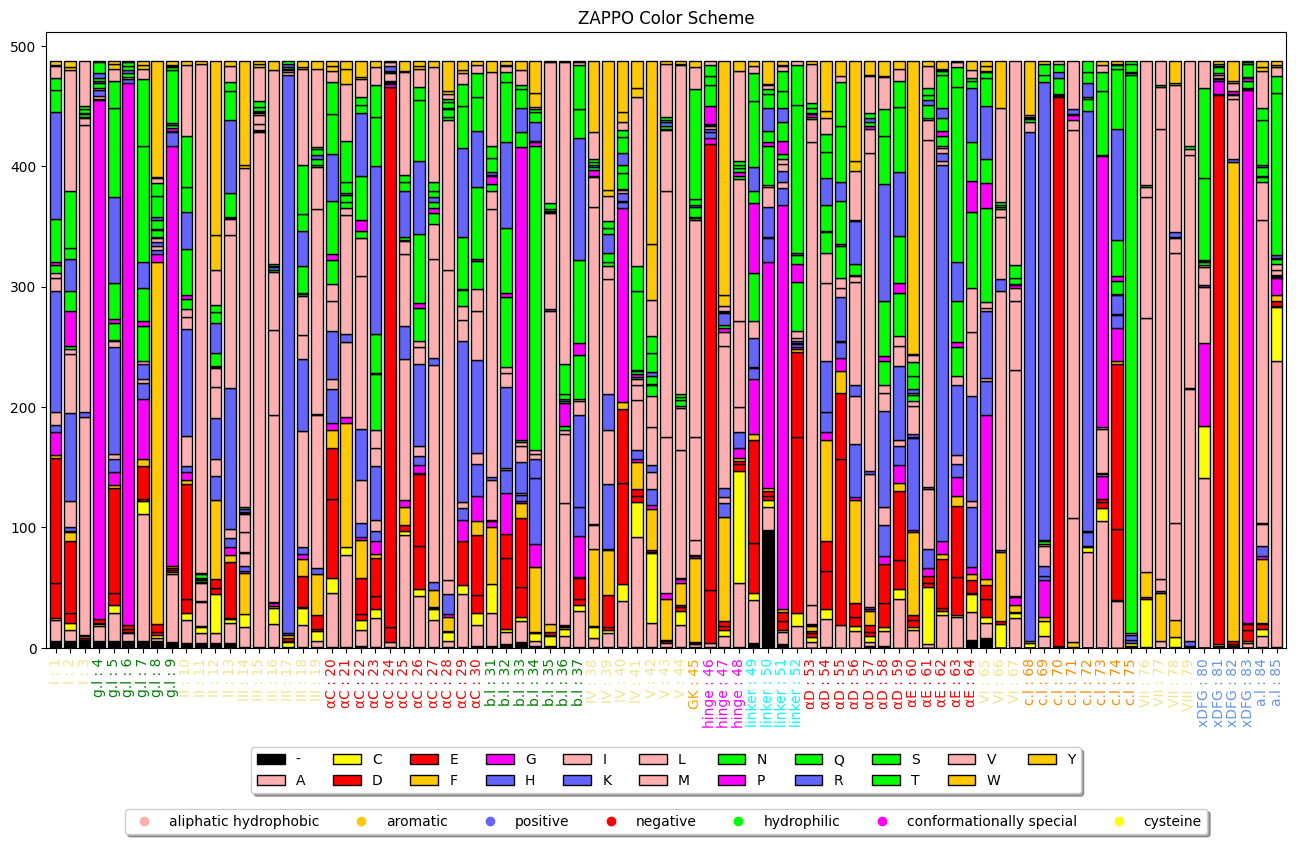

In [8]:
# change x-axis lablel to include KLIFS pocket region
list_cols = [[f"{key} : {i}" for i in range(val["start"], val["end"] + 1)] \
             for key, val in klifs.DICT_POCKET_KLIFS_REGIONS.items()]
list_cols = list(chain.from_iterable(list_cols))
df_pocket_pivot.columns = list_cols

# match x-axis label colors to KLIF pocket region colors
list_axis_col = [[val["color"]] * (val["end"] + 1 - val["start"]) \
                 for _, val in klifs.DICT_POCKET_KLIFS_REGIONS.items()]
list_axis_col = list(chain.from_iterable(list_axis_col))

list_cols = list(colors.DICT_COLORS.keys())
for cols in list_cols:
    print(cols)
    str_col = cols
    dict_col = colors.DICT_COLORS[str_col]["DICT_COLORS"]
    list_fill_col = [colors.map_single_letter_aa_to_color(i, dict_col) \
                     for i in df_pocket_pivot.index.tolist()]
    
    if len(set(list_fill_col)) > 9:
        edgecol = "white"
        colwidth = 0.9
    else:
        edgecol = "black"
        colwidth = 0.8
    
    ax = df_pocket_pivot.T.plot(kind='bar', 
                                stacked=True, 
                                figsize=(16, 8),
                                color=list_fill_col,
                                edgecolor = edgecol, 
                                width = colwidth);
    
    for xtick, color in zip(ax.get_xticklabels(), list_axis_col):
        xtick.set_color(color)
    
    dict_annot = colors.DICT_COLORS[str_col]["DICT_ANNOTATION"]
    if dict_annot is None:
        ax.legend(loc="upper center", 
                  bbox_to_anchor=(0.5, -0.15),
                  fancybox=True, 
                  shadow=True, 
                  ncol=11)
    else:
        l1 = ax.legend(loc="upper center", 
                       bbox_to_anchor=(0.5, -0.15),
                       fancybox=True, 
                       shadow=True, 
                       ncol=11)
        handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for _, color in dict_annot.items()]
        l2 = ax.legend(handlelist,
                       list(dict_annot.keys()),
                       loc="upper center", 
                       bbox_to_anchor=(0.5, -0.25),
                       fancybox=True, 
                       shadow=True, 
                       ncol=len(dict_annot))
        ax.add_artist(l1)
    plt.title(f"{cols} Color Scheme")
    plt.savefig(f"KLIFS_pocket_{cols}.pdf", bbox_inches="tight");

## Assess inter-KLIFS region

## In progress

In [4]:
import numpy as np
from copy import deepcopy

from missense_kinase_toolkit.databases import aligners
from missense_kinase_toolkit.databases.utils import try_except_substraction

In [557]:
list_cols

['II:III', 'III:αC', 'IV:V', 'hinge:linker', 'αD:αE', 'αE:VI', 'VII:VIII']

In [467]:

dict_fasta = {i: {} for i in list_cols}

for idx, row in df_inter.loc[:, list_cols].iterrows():
    for col in list_cols:
        start = row[col][0]
        end = row[col][1]
        if start is not None and end is not None:
            if end-start == 0:
                dict_fasta[col][dict_klifs[idx].hgnc_name] = None
            else:
                dict_fasta[col][dict_klifs[idx].hgnc_name] = \
                dict_klifs[idx].UniProt.canonical_seq[int(start)-1:int(end)-1]
        else:
            dict_fasta[col][dict_klifs[idx].hgnc_name] = None

dict_inter = deepcopy(dict_fasta)
for key, val in dict_fasta.items():
    list_hgnc_seq, list_seq = [], []
    for hgnc, seq in val.items():
        if seq is not None:
            list_hgnc_seq.append(hgnc)
            list_seq.append(seq)
    if len(list_seq) > 2:
        aligner_temp = aligners.ClustalOmegaAligner(list_seq)
        dict_inter[key].update(dict(zip(list_hgnc_seq, aligner_temp.list_alignments)))
    else:
        # hinge:linker - {'ATR': 'N', 'CAMKK1': 'L'}
        # αE:VI - {'MKNK1': 'DKVSLCHLGWSAMAPSGLTAAPTSLGSSDPPTSASQVAGTT'}
        dict_inter[key].update(dict(zip(list_hgnc_seq, list_seq)))

for key_outer, dict_inner in dict_inter.items():
    max_len = max([len(val_inner) for key_inner, val_inner \
                   in dict_inner.items() if val_inner is not None])
    for key_inner, val_inner in dict_inner.items():
        if val_inner is None:
            dict_inter[key_outer][key_inner] = "-" * max_len

In [315]:
def recursive_idx_search(
    idx: int, 
    in_dict: dict[str, int], 
    decreasing: bool,
):
    if idx == 0:
        return "NONE"
    list_keys = list(in_dict.keys())
    if in_dict[list_keys[idx]] is None:
        if decreasing:
            idx = recursive_idx_search(idx-1, in_dict, True)
        else:
            idx = recursive_idx_search(idx+1, in_dict, False)
    return idx

In [316]:
def find_intra_gaps(
    dict_in: dict[str, int],
    bool_bl: True,
):
    if bool_bl:
        region, idx_in, idx_out = "b.l", 1, 2
    else:
        region, idx_in, idx_out = "linker", 0, 1

    list_keys = list(dict_in.keys())
    list_idx = [idx for idx, i in enumerate(dict_in.keys()) if region in i]
    
    #TODO: ATR and CAMKK1 have inter hinge:linker region
    start = list_idx[idx_in]
    end = list_idx[idx_out]

    if dict_in[list_keys[start]] is None:
        start = recursive_idx_search(start-1, dict_in, True)
    if dict_in[list_keys[end]] is None:
        end = recursive_idx_search(end+1, dict_in, False)

    # STK40 has no b.l region or preceding
    if start == "NONE":
        return None

    return (dict_in[list_keys[start]], dict_in[list_keys[end]])

In [536]:
def return_intra_gap_substr(
    dict_klifs2uniprot, 
    uniprot_seq, 
    bl_bool
):
    tuple_idx = find_intra_gaps(dict_klifs2uniprot, bl_bool)
    if tuple_idx is None:
        return None
    else:
        start, end = tuple_idx[0], tuple_idx[1]
        if end - start == 1:
            return None
        else:
            return uniprot_seq[start:end-1]

In [ ]:
def replace_none_with_max_len(dict_in):
    dict_max_len = {key1: max([len(val2) for key2, val2 in val1.items() \
                               if val2 is not None]) for key1, val1 in dict_in.items()}

    for region, length in dict_max_len.items():
        for hgnc, seq in dict_in[region].items():
            if seq is None:
                dict_in[region][hgnc] = "-" * length

In [538]:
# intra regions
list_intra_regions = ["b.l_intra", "linker_intra"]

dict_intra = {i : {hgnc: None for hgnc in dict_klifs.keys()}\
              for i in list_intra_regions}

for region in list_intra_regions:
    list_seq, list_hgnc = [], []
    for key, val in dict_klifs.items():
        if region.split("_")[0] == "b.l":
            temp = return_intra_gap_substr(val.KLIFS2UniProt, val.UniProt.canonical_seq, True)
        else:
            temp = return_intra_gap_substr(val.KLIFS2UniProt, val.UniProt.canonical_seq, False)
        if temp is not None:
            list_seq.append(temp)
            list_hgnc.append(key)

    aligner_temp = aligners.ClustalOmegaAligner(list_seq)
    dict_intra[region].update(dict(zip(list_hgnc, aligner_temp.list_alignments)))

dict_max_len = {key1: max([len(val2) for key2, val2 in val1.items() if val2 is not None])\
                for key1, val1 in dict_intra.items()}

for region, length in dict_max_len.items():
    for hgnc, seq in dict_intra[region].items():
        if seq is None:
            dict_intra[region][hgnc] = "-" * length

In [490]:
def reverse_order_dict_of_dict(
    dict_in: dict[str, dict[str, int | None]]
) -> dict[str, dict[str, int | None]]:
    """Reverse order of dictionary of dictionaries.
    
    Parameters
    ----------
    dict_in : dict[str, dict[str, int | None]]
        Dictionary of dictionaries
        
    Returns
    -------
    dict_out : dict[str, dict[str, int | None]]
        Dictionary of dictionaries with reversed order

    """
    dict_out = {key1: {key2 : dict_in[key2][key1] for key2 in dict_in.keys()}\
                for key1 in set(chain(*[list(j.keys()) for j in dict_in.values()]))}
    return dict_out

In [539]:
list_inter_regions = list(dict_align.keys())

list_idx_inter = list(chain(*[list(idx for idx, j in enumerate(list_region) \
                                   if j == i.split(":")[0]) for i in list_inter_regions]))

list_region_combo = deepcopy(list_region)
i = 0
for idx, val in zip(list_idx_inter, list_inter_regions):
    list_region_combo.insert(idx+i+1, val)
    i += 1

idx = list_region_combo.index("b.l")
list_region_combo[idx:idx+1] = "b.l_1", "b.l_intra", "b.l_2"

idx = list_region_combo.index("linker")
list_region_combo[idx:idx+1] = "linker_1", "linker_intra", "linker_2"

dict_full_klifs_region = {hgnc: {region: None for region in list_region_combo}\
                          for hgnc in dict_klifs.keys()}

dict_inter_reverse = reverse_order_dict_of_dict(dict_inter)
dict_intra_reverse = reverse_order_dict_of_dict(dict_intra)

for hgnc, val in dict_klifs.items():
    dict_actual = dict(zip(list_region, val.KLIFSPocket.list_klifs_substr_actual))
    for region, seq in dict_actual.items():
        if region == "b.l":
            dict_full_klifs_region[hgnc]["b.l_1"] = seq[0:2]
            dict_full_klifs_region[hgnc]["b.l_2"] = seq[2:]
            pass
        elif region == "linker":
            dict_full_klifs_region[hgnc]["linker_1"] = seq[0:1]
            dict_full_klifs_region[hgnc]["linker_2"] = seq[1:]
        else:
            dict_full_klifs_region[hgnc][region] = seq

    
    for region, seq in dict_inter_reverse[hgnc].items():
        dict_full_klifs_region[hgnc][region] = seq

    for region, seq in dict_intra_reverse[hgnc].items():
        dict_full_klifs_region[hgnc][region] = seq

In [548]:
for hgnc, klifs_pocket in dict_klifs.items():
    idx1 = min([i for i in klifs_pocket.KLIFS2UniProt.values() if i is not None])
    idx2 = max([i for i in klifs_pocket.KLIFS2UniProt.values() if i is not None])
    str1 = klifs_pocket.UniProt.canonical_seq[idx1-1:idx2]
    str2 = "".join([*dict_full_klifs_region[hgnc].values()]).replace("-", "")
    if str1 != str2:
        print(hgnc)

In [555]:
dict_klifs_full_seq = dict(zip(dict_full_klifs_region.keys(), 
                               ["".join([*val.values()]) for key, val \
                                in dict_full_klifs_region.items()]))

In [556]:
list_len = [len(i) for i in dict_klifs_full_seq.values()]
print(f"Min: {min(list_len)}, Max: {max(list_len)}")

Min: 1197, Max: 1197


In [148]:
# BUB1B has 1 residues b.l intra region that was captured in αC:b.l since None 
{i: j for i, j in dict_align["αC:b.l"].items() if j != "-"}

{'BUB1B': 'E'}

In [127]:
df_bl = pd.DataFrame([list(j for i, j in val.KLIFS2UniProt.items() if i in list_idx_dict[0]) \
                      for key, val in dict_klifs.items()],
                     columns=list_idx_dict[0], index=dict_klifs.keys())

In [163]:
df_bl[df_bl.isnull().any(axis=1)]

b.l:31  b.l:32  b.l:33  b.l:34  b.l:35  b.l:36  b.l:37
BUB1B      NaN     NaN   818.0   819.0   820.0   821.0   822.0
IGF1R   1057.0  1058.0     NaN  1061.0  1062.0  1063.0  1064.0
INSR    1081.0  1082.0     NaN  1085.0  1086.0  1087.0  1088.0
INSRR   1037.0  1038.0     NaN  1041.0  1042.0  1043.0  1044.0
PIK3R4    77.0     NaN     NaN     NaN    78.0    79.0    80.0
STK40      NaN     NaN     NaN     NaN     NaN     NaN     NaN

In [138]:
df_linker = pd.DataFrame([list(j for i, j in val.KLIFS2UniProt.items() if i in list_idx_dict[1]) \
                          for key, val in dict_klifs.items()],
                         columns=list_idx_dict[1], index=dict_klifs.keys())

In [139]:
df_linker[df_linker.isnull().any(axis=1)]

linker:49  linker:50  linker:51  linker:52
TRIB1       164.0        NaN      165.0        166
CDK7         95.0        NaN       96.0         97
CDK1         84.0        NaN       85.0         86
CDC7        138.0        NaN      139.0        140
CDK2         84.0        NaN       85.0         86
...           ...        ...        ...        ...
UHMK1       115.0        NaN      116.0        117
TBCK         75.0        NaN       76.0         77
GSG2        609.0        NaN      610.0        611
TRIB3       141.0        NaN      142.0        143
RNASEL      438.0      439.0        NaN        440

[103 rows x 4 columns]

In [217]:
[i for i, j in dict_align["hinge:linker"].items() if j != "-"]

['ATR', 'CAMKK1']

In [180]:
df_linker.loc[df_linker["linker:49"].isnull(), ]

linker:49  linker:50  linker:51  linker:52
PKMYT1        NaN      191.0      192.0        193
SCYL1         NaN        NaN       97.0         98
SCYL3         NaN        NaN       86.0         87
STK40         NaN      158.0      159.0        160

In [182]:
dict(zip(dict_klifs["STK40"].KLIFSPocket.list_klifs_region, dict_klifs["STK40"].KLIFSPocket.list_klifs_substr_actual))

{'I:I': '---',
 'g.l:g.l': '------',
 'II:II': '----',
 'III:III': '------',
 'αC:αC': '-----------',
 'b.l:b.l': '-------',
 'IV:IV': '----',
 'V:V': '---',
 'GK:GK': '-',
 'hinge:hinge': '---',
 'linker:linker': '-NLQ',
 'αD:αD': 'HYVIKEK',
 'αE:αE': 'ALHQK',
 'VI:VI': 'NIV',
 'c.l:c.l': 'HRDLKLGN',
 'VII:VII': 'MVL',
 'VIII:xDFG': 'I',
 'xDFG:xDFG': 'TNFC',
 'xDFG:a.l': 'LG'}

In [128]:
df_bl.head()

b.l:31  b.l:32  b.l:33  b.l:34  b.l:35  b.l:36  b.l:37
ABL1     293.0   294.0   296.0   297.0   298.0   299.0   300.0
TNK2     184.0   185.0   187.0   188.0   189.0   190.0   191.0
ACVR2A   239.0   240.0   244.0   245.0   246.0   247.0   248.0
ACVR2B   237.0   238.0   242.0   243.0   244.0   245.0   246.0
ADCK4    297.0   298.0   307.0   308.0   309.0   310.0   311.0

In [223]:
list(dict_klifs["ABL1"].KLIFS2UniProt.keys())[1]

'I:2'

In [224]:
[idx for idx, i in enumerate(dict_klifs["ABL1"].KLIFS2UniProt.keys()) if "linker" in i]

[48, 49, 50, 51]

In [214]:
[idx for idx, i in enumerate(dict_klifs["ABL1"].KLIFS2UniProt.keys()) if "b.l" in i]

[30, 31, 32, 33, 34, 35, 36]

In [121]:
for entry in list_idx_dict:
    for key1, val1 in dict_klifs.items():
        list_temp = 
        for key2, val2 in val1.KLIFS2UniProt.items():
            print(val2)

246
247
248
249
250
251
252
253
254
255
256
257
258
268
269
270
271
272
273
282
283
284
285
286
287
288
289
290
291
292
293
294
296
297
298
299
300
301
302
303
304
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
379
380
381
382
383
384
385
130
131
132
133
134
135
136
137
138
139
140
141
142
155
156
157
158
159
160
173
174
175
176
177
178
179
180
181
182
183
184
185
187
188
189
190
191
192
193
194
195
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
268
269
270
271
272
273
274
196
197
198
199
200
201
202
203
204
205
206
207
208
216
217
218
219
220
221
228
229
230
231
232
233
234
235
236
237
238
239
240
244
245
246
247
248
249
250
251
252
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
338
339


In [103]:
dict_klifs["PIK3R4"].KLIFSPocket.list_klifs_substr_actual[5]

'R---LNS'

In [104]:
dict_klifs["PIK3R4"].KLIFSPocket.list_substring_idxs[5]

[76, 77, 78, 79]

In [125]:
list_err = []
list_start, list_inter, list_end = [], [], []
for idx in list_idx:
    for key, val in dict_klifs.items():
        list_substring_idxs = val.KLIFSPocket.list_substring_idxs[idx]
        try:
            for i in range(min(list_substring_idxs), max(list_substring_idxs)+1):
                if i not in list_substring_idxs:
                    pass
                    # print(i)
        except:
            list_err.append(key)

In [74]:
list_temp = dict_klifs["ABL1"].KLIFSPocket.list_substring_idxs[5]
for i in range(min(list_temp), max(list_temp)+1):
    if i not in list_temp:
        print(i)

294


In [61]:
dict_klifs

{'ABL1': KinaseInfo(hgnc_name='ABL1', uniprot_id='P00519', KinHub=KinHub(kinase_name='Tyrosine-protein kinase ABL1', manning_name=['ABL'], xname=['ABL1'], group=[<Group.TK: 'TK'>], family=[<Family.Other: 'Other'>]), UniProt=UniProt(canonical_seq='MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFG

In [56]:
dict_align.keys()

dict_keys(['II:III', 'III:αC', 'αC:b.l', 'IV:V', 'hinge:linker', 'αD:αE', 'αE:VI', 'VII:VIII'])

In [53]:
[i.split(":")[0] for i in dict_align.keys()]

['II', 'III', 'αC', 'IV', 'hinge', 'αD', 'αE', 'VII']

In [50]:
[max(list(len(val_inner) for key_inner, val_inner in dict_inner.items())) for key_outer, dict_inner in dict_align.items()]

[70, 121, 1, 238, 1, 260, 41, 325]

In [59]:
[i for i, j in dict_align["αC:b.l"].items() if j != "-"]

['BUB1B']

In [31]:
dict_align = deepcopy(dict_fasta)

for key, val in dict_fasta.items():
    list_hgnc_seq, list_seq = [], []
    for hgnc, seq in val.items():
        if seq is not None:
            list_hgnc_seq.append(hgnc)
            list_seq.append(seq)
    if len(list_seq) > 2:
        aligner_temp = aligners.ClustalOmegaAligner(list_seq)
        dict_align[key].update(dict(zip(list_hgnc_seq, aligner_temp.list_alignments)))
    except:
        dict_align[key].update(dict(zip(list_hgnc_seq, list_seq)))

αC:b.l
{'BUB1B': 'E'}
hinge:linker
{'ATR': 'N', 'CAMKK1': 'L'}
αE:VI
{'MKNK1': 'DKVSLCHLGWSAMAPSGLTAAPTSLGSSDPPTSASQVAGTT'}


In [408]:
for key, val in  dict_fasta.items():
    list_temp = []
    for hgnc, seq in val.items():
        if seq is not None:
            list_temp.append(SeqRecord(Seq(seq), id=key + "_" + hgnc, description=""))
    filename = key.replace(":", "_")
    with open(f"../data/{filename}.fasta", "w") as output_handle:
        SeqIO.write(list_temp, output_handle, "fasta")

In [30]:
df_klifs_idx

I:1    I:2    I:3  g.l:4  g.l:5  g.l:6  g.l:7  g.l:8  g.l:9  II:10  \
ABL1    246.0  247.0  248.0  249.0  250.0  251.0  252.0  253.0  254.0  255.0   
TNK2    130.0  131.0  132.0  133.0  134.0  135.0  136.0  137.0  138.0  139.0   
ACVR2A  196.0  197.0  198.0  199.0  200.0  201.0  202.0  203.0  204.0  205.0   
ACVR2B  194.0  195.0  196.0  197.0  198.0  199.0  200.0  201.0  202.0  203.0   
ADCK4   213.0  214.0  215.0  216.0  217.0  218.0  219.0  220.0  221.0  222.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
WEE2    216.0  217.0  218.0  219.0  220.0  221.0  222.0  223.0  224.0  225.0   
RNASEL  369.0  370.0  371.0  372.0  373.0  374.0  375.0  376.0  377.0  378.0   
RIOK2    99.0  100.0  101.0  102.0  103.0  104.0  105.0  106.0  107.0  108.0   
ADCK5   204.0  205.0  206.0  207.0  208.0  209.0  210.0  211.0  212.0  213.0   
PAN3    493.0  494.0  495.0  496.0  497.0  498.0  499.0  500.0  501.0  502.0   

        ...  VII:76  VII:77  VII:78  VIII:79  xDFG:80  xDFG:81  xDFG:82  \
ABL1    ...     369     370     371      379      380      381      382   
TNK2    ...     258     259     260      268      269      270      271   
ACVR2A  ...     328     329     330      338      339      340      341   
ACVR2B  ...     327     328     329      337      338      339      340   
ADCK4   ...     373     374     375      384      385      386      387   
...     ...     ...     ...     ...      ...      ...      ...      ...   
WEE2    ...     345     346     347      378      379      380      381   
RNASEL  ...     491     492     493      501      502      503      504   
RIOK2   ...     234     235     236      244      245      246      247   
ADCK5   ...     366     367     368      380      381      382      383   
PAN3    ...     646     647     648      656      657      658      659   

        xDFG:83  a.l:84  a.l:85  
ABL1        383   384.0   385.0  
TNK2        272   273.0   274.0  
ACVR2A      342   343.0   344.0  
ACVR2B      341   342.0   343.0  
ADCK4       388   389.0   390.0  
...         ...     ...     ...  
WEE2        382   383.0   384.0  
RNASEL      505   506.0   507.0  
RIOK2       248   249.0   250.0  
ADCK5       384   385.0   386.0  
PAN3        660   661.0   662.0  

[487 rows x 85 columns]

In [326]:
df_inter.head()

I:g.l          g.l:II          II:III          III:αC  \
ABL1    (249.0, 249.0)  (255.0, 255.0)  (259.0, 268.0)  (274.0, 282.0)   
TNK2    (133.0, 133.0)  (139.0, 139.0)  (143.0, 155.0)  (161.0, 173.0)   
ACVR2A  (199.0, 199.0)  (205.0, 205.0)  (209.0, 216.0)  (222.0, 228.0)   
ACVR2B  (197.0, 197.0)  (203.0, 203.0)  (207.0, 214.0)  (220.0, 226.0)   
ADCK4   (216.0, 216.0)  (222.0, 222.0)  (226.0, 234.0)  (240.0, 286.0)   

                αC:b.l          b.l:IV            IV:V            V:GK  \
ABL1    (293.0, 293.0)  (301.0, 301.0)  (305.0, 312.0)  (315.0, 315.0)   
TNK2    (184.0, 184.0)  (192.0, 192.0)  (196.0, 202.0)  (205.0, 205.0)   
ACVR2A  (239.0, 239.0)  (249.0, 249.0)  (253.0, 264.0)  (267.0, 267.0)   
ACVR2B  (237.0, 237.0)  (247.0, 247.0)  (251.0, 262.0)  (265.0, 265.0)   
ADCK4   (297.0, 297.0)  (312.0, 312.0)  (316.0, 319.0)  (322.0, 322.0)   

              GK:hinge    hinge:linker       linker:αD           αD:αE  \
ABL1    (316.0, 316.0)  (319.0, 319.0)  (323.0, 323.0)  (330.0, 353.0)   
TNK2    (206.0, 206.0)  (209.0, 209.0)  (213.0, 213.0)  (220.0, 242.0)   
ACVR2A  (268.0, 268.0)  (271.0, 271.0)  (275.0, 275.0)  (282.0, 312.0)   
ACVR2B  (266.0, 266.0)  (269.0, 269.0)  (273.0, 273.0)  (280.0, 311.0)   
ADCK4   (323.0, 323.0)  (326.0, 326.0)  (332.0, 332.0)  (339.0, 357.0)   

                 αE:VI          VI:c.l         c.l:VII        VII:VIII  \
ABL1    (358.0, 358.0)  (361.0, 361.0)  (369.0, 369.0)  (372.0, 379.0)   
TNK2    (247.0, 247.0)  (250.0, 250.0)  (258.0, 258.0)  (261.0, 268.0)   
ACVR2A  (317.0, 317.0)  (320.0, 320.0)  (328.0, 328.0)  (331.0, 338.0)   
ACVR2B  (316.0, 316.0)  (319.0, 319.0)  (327.0, 327.0)  (330.0, 337.0)   
ADCK4   (362.0, 362.0)  (365.0, 365.0)  (373.0, 373.0)  (376.0, 384.0)   

             VIII:xDFG  
ABL1    (380.0, 380.0)  
TNK2    (269.0, 269.0)  
ACVR2A  (339.0, 339.0)  
ACVR2B  (338.0, 338.0)  
ADCK4   (385.0, 385.0)

In [367]:
df_length.describe()

I:g.l  g.l:II      II:III      III:αC      αC:b.l  b.l:IV        IV:V  \
count  481.0   482.0  483.000000  486.000000  486.000000   486.0  486.000000   
mean     0.0     0.0    9.749482   10.740741    0.002058     0.0    8.549383   
std      0.0     0.0    2.777610    5.336769    0.045361     0.0   10.500105   
min      0.0     0.0    6.000000    1.000000    0.000000     0.0    3.000000   
25%      0.0     0.0    9.000000    9.000000    0.000000     0.0    7.000000   
50%      0.0     0.0    9.000000   10.000000    0.000000     0.0    7.000000   
75%      0.0     0.0    9.000000   12.000000    0.000000     0.0    8.000000   
max      0.0     0.0   43.000000   48.000000    1.000000     0.0  227.000000   

        V:GK  GK:hinge  hinge:linker  linker:αD       αD:αE       αE:VI  \
count  486.0     486.0    486.000000      487.0  487.000000  487.000000   
mean     0.0       0.0      0.004115        0.0   26.002053    0.084189   
std      0.0       0.0      0.064084        0.0   15.945702    1.857887   
min      0.0       0.0      0.000000        0.0   16.000000    0.000000   
25%      0.0       0.0      0.000000        0.0   21.000000    0.000000   
50%      0.0       0.0      0.000000        0.0   22.000000    0.000000   
75%      0.0       0.0      0.000000        0.0   24.000000    0.000000   
max      0.0       0.0      1.000000        0.0  170.000000   41.000000   

       VI:c.l  c.l:VII    VII:VIII  VIII:xDFG  
count   487.0    487.0  487.000000      487.0  
mean      0.0      0.0    9.786448        0.0  
std       0.0      0.0   20.027337        0.0  
min       0.0      0.0    6.000000        0.0  
25%       0.0      0.0    7.000000        0.0  
50%       0.0      0.0    7.000000        0.0  
75%       0.0      0.0    8.000000        0.0  
max       0.0      0.0  305.000000        0.0

In [51]:
# CHECK
region1 = "II"
idx1 = [idx for idx, i in enumerate(klifs.DICT_POCKET_KLIFS_REGIONS.keys()) if i == region1][0]
str1 = [i for idx, i in enumerate(dict_klifs["ABL1"].KLIFSPocket.list_klifs_substr_actual) if idx == idx1]

region2 = "III"
idx2 = [idx for idx, i in enumerate(klifs.DICT_POCKET_KLIFS_REGIONS.keys()) if i == region2][0]
str2 = [i for idx, i in enumerate(dict_klifs["ABL1"].KLIFSPocket.list_klifs_substr_actual) if idx == idx2]

abl_test = str1[0] + dict_fasta[f"{region1}:{region2}"]["ABL1"] + str2[0]

klifs.KLIFSPocket.return_idx_of_substring_in_superstring(dict_klifs["ABL1"].UniProt.canonical_seq, abl_test)

[254]

In [353]:
list_split = [i.split(":")[0] for i in dict_fasta.keys()]

In [371]:
protein = "ABL1"

dict_test = dict(zip(klifs.DICT_POCKET_KLIFS_REGIONS.keys(), 
                     dict_klifs[protein].KLIFSPocket.list_klifs_substr_actual))

dict_temp = {}
for key, val in dict_test.items():
    dict_temp[key] = val
    if key in list_split:
        key2 = [i for i, j in zip(dict_fasta.keys(), list_split) if j == key][0]
        dict_temp[key2] = dict_fasta[key2][protein]

In [390]:
klifs.KLIFSPocket.return_idx_of_substring_in_superstring(dict_klifs["ABL1"].UniProt.canonical_seq,
                                                         "".join([val for key, val in dict_temp.items() if key in list(dict_temp.keys())[-11:] if val is not None]))

[322]

In [374]:
klifs.KLIFSPocket.return_idx_of_substring_in_superstring(dict_klifs["ABL1"].UniProt.canonical_seq, 
                                                         "EVYEGVWKKYSLTVAVKTL")

[254]

In [364]:
"".join([val for _, val in dict_temp.items() if val is not None])

'HKLGGGQYGEVYEGVWKKYSLTVVAVKTLKEDTMEVEEEFLKEAAVMKEIKPNLVQLLGVCTREPPFYYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYYLEKKNFIHRDLAARNCLVGENHLVKVVADFGLS'

In [373]:
klifs.KLIFSPocket.return_idx_of_substring_in_superstring(dict_klifs["ABL1"].UniProt.canonical_seq, 
                                                         "".join([val for _, val in dict_temp.items() if val is not None]))

[]

In [337]:
[key for key, val in dict_fasta["II:III"].items() if val is None]

['STK40', 'RPS6KC1', 'TBCK', 'TEX14']

In [39]:
for idx, row in df_klifs_idx.iterrows():
    print(dict_klifs[idx].UniProt.canonical_seq[row["I:1"]-1:row["a.l:85"]-1])

TypeError: slice indices must be integers or None or have an __index__ method

In [32]:
dict_klifs["ABL1"].UniProt.canonical_seq

'MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSS